In [72]:
# Insert local path to MAVE-NN at beginning of Python's path
import sys
sys.path.insert(0, '/Users/tomroeschinger/git/mavenn')

#Load mavenn
import mavenn


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
df_map = pd.read_csv(
    "filtered_mapping.csv" 
)


In [ ]:
# Get twist order to get wild type sequences
df_seqs = pd.read_csv("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs.iloc[list(range(0, 119*1501, 1501))]

df_wt["promoter_seq"] =  [str(x[27:186]) for x in df_wt.sequence]
df_wt = df_wt[["promoter", "promoter_seq"]].rename(columns={"promoter": "name", "promoter_seq": "wt_seq"})

df_map = df_map.merge(df_wt, on="name", how="left")

/var/folders/67/2rd1gct91876bvjs_7ny9rcw0000gn/T/ipykernel_69406/1604040275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wt["promoter_seq"] =  [str(x[27:186]) for x in df_wt.sequence]


In [53]:
def get_dataset(i):
    if  os.path.isfile("../../../data/extracted_barcodes/20231207_barcode/$(i)_DNA_collapsed.txt"):
        df_DNA = pd.read_csv(
            f"../../../data/extracted_barcodes/20231207_barcode/{i}_DNA_collapsed.txt", 
            delim_whitespace=True, 
            names=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = pd.read_csv(
            f"../../../data/extracted_barcodes/20231207_barcode/{i}_RNA_collapsed.txt", 
            delim_whitespace=True, 
            names=["ct_1", "barcode"]
        )
    else:
        df_DNA = pd.read_csv(
            f"../../../data/extracted_barcodes/20230907_barcode/temp/{i}_DNA_collapsed.txt", 
            delim_whitespace=True, 
            names=["ct_0", "barcode"]
        )
        # import RNA
        df_RNA = pd.read_csv(
            f"../../../data/extracted_barcodes/20230907_barcode/temp/{i}_RNA_collapsed.txt", 
            delim_whitespace=True, 
            names=["ct_1", "barcode"]
        )
    
    # merge DNA and RNA reads
    df = df_DNA.merge(df_RNA, on="barcode", how="outer", )
    
    # replace missing reads with 0
    df.fillna(0, inplace=True)
    
    
    # identify promoter sequences
    df = df.merge(df_map, on="barcode", how="inner")

    df['ct'] = df['ct_0'] + df['ct_1']

    # Compute relative counts, adding a pseudo count
    df['relative_counts'] = (df['ct_1'] + 1) / (df['ct_0'] + 1)
    return df

In [58]:
df = get_dataset("1-1")

In [129]:
training_p = 0.95
validation_p = 0.025
test_p = 1 - training_p - validation_p

df['x'] = np.log10(df['relative_counts'])
df['set'] = np.random.choice(["training", "validation", "test"], p=[training_p, validation_p, test_p], size=len(df))

In [130]:
df

,ct_0,barcode,ct_1,promoter,map_count,name,wt_seq,ct,relative_counts,set,x
0,399.0,ATTTATTCAAGGCTCTTAAT,246.0,TATCCTGAGGAGTTGTATCAGTTCAGGCCTTTCGGACCTTGTGCCG...,368,tfaE_stfE_predicted,TGTCCTGAGCAGTTTTTTCAGTCCCGGCCTTTCGGACTTTGTGCCG...,645.0,0.617500,training,-0.209363
1,385.0,TATACGCGACCCAAGACTGT,226.0,GGATCCACAAAGCGAAAGCTATGGTAACACAGTCAGGATGCCACAG...,237,crpp2,GGAGACACAAAGCGAAAGCTATGCTAAAACAGTCAGGATGCTACAG...,611.0,0.588083,training,-0.230561
2,234.0,TTCTTTTCAACGAGCTTCGA,118.0,TGCTGGACTCATTCCGTATCGGCCCTACAGAAGATGCTGAACGCTG...,190,TSS_18061_regulondb,TGCTGGACTCATTCGGCATCGGCGCTACAGAAGATGCAGAACGCTT...,352.0,0.506383,training,-0.295521
3,215.0,CCATCTCAAGGCCATAGTGT,138.0,TGATGGACTCATTCTGCATCGGCGCTACAGAAGATGCAGTACGCTT...,193,TSS_18061_regulondb,TGCTGGACTCATTCGGCATCGGCGCTACAGAAGATGCAGAACGCTT...,353.0,0.643519,training,-0.191439
4,207.0,CTGCGTGGCGCGAGAGAGGA,109.0,GGTCCCTGATCCTACGTGGACGTGGTTTGCGTAGCTATGGCTATTT...,124,yadI_predicted,GGTCGCTGATCCAACGTGGACGTGGTTTGCGTAGCTAAGGCTATTT...,316.0,0.528846,training,-0.276671
...,...,...,...,...,...,...,...,...,...,...,...
682138,0.0,AAAAAAAGAGTAGGAGCCAA,1.0,GTGATAGAATCGCCACTGGGCGGAGATGAAAATGAGCAACTCCAAG...,87,rcsBp2,GTGACAGAATCGCCTCTGGGCGGAGATGAAAATGCGCAACTCCATG...,1.0,2.000000,training,0.301030
682139,0.0,AAAAAAACAGACCTAGGACG,1.0,GAAGCAATCATAAATCAAATCGGATTTCACTATATACTATCACTTG...,115,lppp2,GAAGCAATAAAAAATCAAATCGGATTTCACTATATAATCTCACTTT...,1.0,2.000000,training,0.301030
682140,0.0,AAAAAAAATGCTGTCATGTG,1.0,CCGGAAGGTAACTTCTTCGGCAAAATCCTTGATTACATTAAATTAG...,92,ybeDp,CCGGAAGGTAACTTCTTCGGCAAAATCATTGATTACATTAAATTAA...,1.0,2.000000,training,0.301030
682141,0.0,AAAAAAAACATATACTAAGA,1.0,CATTGGCTGACCCGGTTACGGGATCACACTCATCGGGTCGGATAAC...,91,yqjE_yqjK_yqjD_yqjC_predicted,CAGTGGCTGACCCGGTTACGGGATAACTCTCATCGCTTCGGATAAC...,1.0,2.000000,training,0.301030


In [131]:
# Split dataset
trainval_df, test_df = mavenn.split_dataset(df.loc[df.name == 'dicCp', :])

# Preview trainval_df
print('trainval_df:')
trainval_df

Training set   :    6,168 observations (  95.01%)
Validation set :      149 observations (   2.30%)
Test set       :      175 observations (   2.70%)
-------------------------------------------------
Total dataset  :    6,492 observations ( 100.00%)

trainval_df:


,validation,ct_0,barcode,ct_1,promoter,map_count,name,wt_seq,ct,relative_counts,x
0,False,29.0,AAAAAAATCGTGGTAATGGT,5.0,GAGGTTCTTCCGACGATACCTGATGCGTTCGTCGATAGTTACATTT...,109,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,34.0,0.200,-0.698970
1,False,7.0,GTCCCTCTTAGTAGCGTATA,2.0,GAGGTTTTTTCGTCGATACGTGATGCATTCGCCGACAGTTAAATTT...,190,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,9.0,0.375,-0.425969
2,False,7.0,CTTCACGTTGACGACTAGGT,14.0,GAGCTTTATCCGACGATATCTGATGCGTTCGCGGATAGTTAAATTT...,5,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,21.0,1.875,0.273001
3,False,7.0,CCTTAGAGCCAGATTGGCGT,1.0,GAGGTTTCTCCGACGATACTTGATGCCTTCGGCGACAGTTAAGTTT...,344,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,8.0,0.250,-0.602060
4,False,7.0,ATACATGCTACAGAGTCTGA,0.0,GAGGTTTTTCCGACGATACCGGATGCGGTTGGAGATAGTCAAACTT...,276,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,7.0,0.125,-0.903090
...,...,...,...,...,...,...,...,...,...,...,...
6312,False,0.0,AAAATTGGCTCCATTGCTCA,1.0,GGGGTTCTTCCGACGATATCTGATGCGTTCGCAGATGGTTAAATTT...,95,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,1.0,2.000,0.301030
6313,False,0.0,AAAATCCGTTACTCACGGCC,1.0,GAGGTTTTTCCGTCGATCCCTGACGCGTTCGCCGATCGTTAAAATT...,57,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,1.0,2.000,0.301030
6314,False,0.0,AAAAGTCTTTCTGTTAACGA,1.0,GAGGTGTTTATGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,120,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,1.0,2.000,0.301030
6315,False,0.0,AAAAGTAAAACTACAGTGTA,1.0,GAGGTTATTCCGACGATATCTGATGCGTCCGCCGATAGTTAACTTT...,49,dicCp,GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTT...,1.0,2.000,0.301030


In [145]:
# Define model
model = mavenn.Model(L=160,
                     alphabet='dna',
                     gpmap_type='additive',
                     regression_type='MPA',
                     ge_noise_model_type='Gaussian')

# Set training data
model.set_data(x=trainval_df['promoter'],
               y=trainval_df[['ct_0', 'ct_1']],
               validation_flags=trainval_df['validation'])

# Train model
model.fit(learning_rate=1e-4,
          epochs=500,
          batch_size=32,
          early_stopping=False,
          verbose=False);


N = 6,317 observations set as training data.
Using 2.4% for validation.
Data shuffled.
Time to set data: 0.131 sec.
Training time: 14.4 seconds


In [146]:
# Compute variational information on test data
I_var, dI_var =  model.I_variational(x=test_df['promoter'], y=test_df[['ct_0', 'ct_1']])
print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['promoter'], y=test_df[['ct_0', 'ct_1']])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_var: 0.075 +- 0.043 bits
test_I_pred: 0.010 +- 0.033 bits


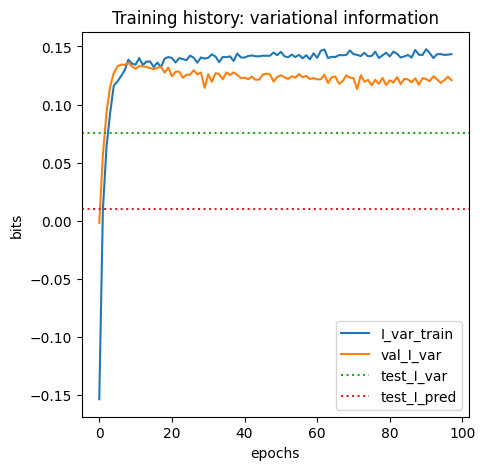

In [147]:


# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'],
        label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'],
        label=r'val_I_var')

# Show I_var_test, the variational information of the final model on test data
ax.axhline(I_var, color='C2', linestyle=':',
           label=r'test_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':',
           label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
#ax.set_ylim([0, 1.2*I_pred])
ax.legend()


<BarContainer object of 158 artists>

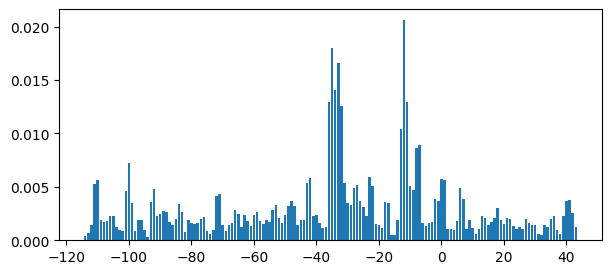

In [148]:
prob_mat = np.transpose(np.transpose(np.exp(model.get_theta()['theta_lc'])) / np.sum(np.transpose(np.exp(model.get_theta()['theta_lc'])), axis=0))
mut_info = np.sum(prob_mat * np.log2(prob_mat / 0.25), axis=1)


fig, ax = plt.subplots(figsize=(7, 3))

d = 1
ax.bar(range(-115+d, 45-d), [np.mean(mut_info[i-d:i+d]) for i in range(d, 160-d)])